In [48]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [5]:
(raw_train, raw_validation, raw_test), metadata=tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

2023-07-06 20:14:40.056050: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dataset cats_vs_dogs downloaded and prepared to /Users/minsoo/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


1


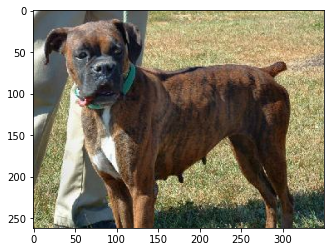

In [6]:
for image, label in raw_train.take(1):
    plt.imshow(image)
    print(label.numpy())

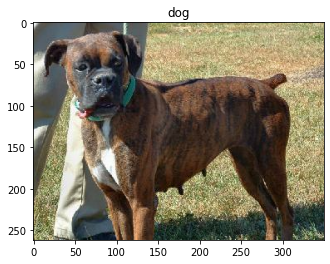

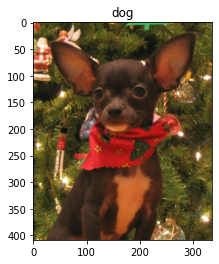

In [7]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

In [8]:
IMG_SIZE = 160

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [9]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [10]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [11]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 160, 160, 3])

In [13]:
# 인증서 문제로 임시 조치, SSL 해제 후 다운로드
# import ssl

# ssl._create_default_https_context = ssl._create_unverified_context

IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [14]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [15]:
base_model.trainable = False

base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [17]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

prediction_batch

(32, 1)


<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[ 0.6386614 ],
       [ 0.03802776],
       [-0.9029471 ],
       [ 0.23508584],
       [ 0.47259125],
       [-0.13698545],
       [-0.8622215 ],
       [ 0.94721127],
       [-0.29809958],
       [-1.6112696 ],
       [-1.7333331 ],
       [-2.2293866 ],
       [-1.6644458 ],
       [-2.9212976 ],
       [-0.97216904],
       [-0.32628962],
       [-0.66687346],
       [-0.07894737],
       [-0.5387411 ],
       [ 0.7224857 ],
       [-2.1251383 ],
       [-1.3287201 ],
       [-2.5833235 ],
       [-1.1047456 ],
       [-1.1178962 ],
       [-0.7478262 ],
       [ 0.38283932],
       [ 0.05951202],
       [-1.2522686 ],
       [-2.0221736 ],
       [-1.0996664 ],
       [ 1.3249488 ]], dtype=float32)>

In [18]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

In [20]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [22]:
initial_epochs = 10
validation_steps=20

loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

 5/20 [======>.......................] - ETA: 1s - loss: 0.6755 - accuracy: 0.5063

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


16/20 [=======================>......] - ETA: 0s - loss: 0.6365 - accuracy: 0.5371

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


20/20 [==============================] - 3s 96ms/step - loss: 0.6324 - accuracy: 0.5359


In [23]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
165/582 [=======>......................] - ETA: 31s - loss: 0.1156 - accuracy: 0.9540

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 29s - loss: 0.1045 - accuracy: 0.9586

207/582 [=========>....................] - ETA: 28s - loss: 0.1012 - accuracy: 0.9601

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 23s - loss: 0.0949 - accuracy: 0.9618

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 7s - loss: 0.0760 - accuracy: 0.9704

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 6s - loss: 0.0756 - accuracy: 0.9704

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 5s - loss: 0.0751 - accuracy: 0.9707

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 3s - loss: 0.0733 - accuracy: 0.9715

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 2s - loss: 0.0732 - accuracy: 0.9716

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0713 - accuracy: 0.9723

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 55s 93ms/step - loss: 0.0713 - accuracy: 0.9723 - val_loss: 0.0454 - val_accuracy: 0.9845
Epoch 2/10
166/582 [=======>......................] - ETA: 36s - loss: 0.0439 - accuracy: 0.9846

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 33s - loss: 0.0425 - accuracy: 0.9850

208/582 [=========>....................] - ETA: 32s - loss: 0.0425 - accuracy: 0.9847

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 26s - loss: 0.0441 - accuracy: 0.9823

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 8s - loss: 0.0450 - accuracy: 0.9835

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 7s - loss: 0.0446 - accuracy: 0.9836

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 6s - loss: 0.0441 - accuracy: 0.9838

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 3s - loss: 0.0440 - accuracy: 0.9835

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 3s - loss: 0.0442 - accuracy: 0.9835

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0436 - accuracy: 0.9836

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 60s 103ms/step - loss: 0.0436 - accuracy: 0.9836 - val_loss: 0.0430 - val_accuracy: 0.9854
Epoch 3/10
166/582 [=======>......................] - ETA: 36s - loss: 0.0398 - accuracy: 0.9861

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 34s - loss: 0.0405 - accuracy: 0.9861

208/582 [=========>....................] - ETA: 33s - loss: 0.0399 - accuracy: 0.9862

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 26s - loss: 0.0431 - accuracy: 0.9845

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 8s - loss: 0.0404 - accuracy: 0.9855

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 7s - loss: 0.0402 - accuracy: 0.9856

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 6s - loss: 0.0406 - accuracy: 0.9854

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 3s - loss: 0.0403 - accuracy: 0.9854

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 3s - loss: 0.0404 - accuracy: 0.9853

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0393 - accuracy: 0.9859

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 60s 103ms/step - loss: 0.0393 - accuracy: 0.9859 - val_loss: 0.0438 - val_accuracy: 0.9862
Epoch 4/10
166/582 [=======>......................] - ETA: 37s - loss: 0.0355 - accuracy: 0.9876

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 34s - loss: 0.0353 - accuracy: 0.9877

208/582 [=========>....................] - ETA: 33s - loss: 0.0363 - accuracy: 0.9875

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 26s - loss: 0.0377 - accuracy: 0.9863

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 8s - loss: 0.0377 - accuracy: 0.9869

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 7s - loss: 0.0381 - accuracy: 0.9868

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 6s - loss: 0.0376 - accuracy: 0.9870

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 3s - loss: 0.0366 - accuracy: 0.9873

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 3s - loss: 0.0364 - accuracy: 0.9873

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0362 - accuracy: 0.9872

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 60s 102ms/step - loss: 0.0362 - accuracy: 0.9872 - val_loss: 0.0442 - val_accuracy: 0.9858
Epoch 5/10
165/582 [=======>......................] - ETA: 37s - loss: 0.0319 - accuracy: 0.9881

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 34s - loss: 0.0341 - accuracy: 0.9875

207/582 [=========>....................] - ETA: 33s - loss: 0.0329 - accuracy: 0.9881

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 26s - loss: 0.0360 - accuracy: 0.9864

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 8s - loss: 0.0354 - accuracy: 0.9873

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 7s - loss: 0.0350 - accuracy: 0.9874

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 6s - loss: 0.0353 - accuracy: 0.9873

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 3s - loss: 0.0348 - accuracy: 0.9876

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 3s - loss: 0.0347 - accuracy: 0.9876

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0343 - accuracy: 0.9879

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 59s 101ms/step - loss: 0.0343 - accuracy: 0.9879 - val_loss: 0.0424 - val_accuracy: 0.9871
Epoch 6/10
166/582 [=======>......................] - ETA: 37s - loss: 0.0314 - accuracy: 0.9893

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 34s - loss: 0.0343 - accuracy: 0.9878

208/582 [=========>....................] - ETA: 33s - loss: 0.0343 - accuracy: 0.9878

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 26s - loss: 0.0350 - accuracy: 0.9872

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 8s - loss: 0.0341 - accuracy: 0.9876

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 7s - loss: 0.0344 - accuracy: 0.9875

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 6s - loss: 0.0342 - accuracy: 0.9875

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 3s - loss: 0.0335 - accuracy: 0.9878

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 3s - loss: 0.0334 - accuracy: 0.9878

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0325 - accuracy: 0.9882

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 60s 102ms/step - loss: 0.0325 - accuracy: 0.9882 - val_loss: 0.0446 - val_accuracy: 0.9862
Epoch 7/10
166/582 [=======>......................] - ETA: 38s - loss: 0.0296 - accuracy: 0.9889

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 35s - loss: 0.0314 - accuracy: 0.9886

208/582 [=========>....................] - ETA: 34s - loss: 0.0307 - accuracy: 0.9884

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 27s - loss: 0.0329 - accuracy: 0.9874

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 8s - loss: 0.0324 - accuracy: 0.9877

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 7s - loss: 0.0319 - accuracy: 0.9879

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 6s - loss: 0.0320 - accuracy: 0.9879

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 3s - loss: 0.0313 - accuracy: 0.9881

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 3s - loss: 0.0312 - accuracy: 0.9882

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0309 - accuracy: 0.9884

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 60s 103ms/step - loss: 0.0309 - accuracy: 0.9884 - val_loss: 0.0432 - val_accuracy: 0.9867
Epoch 8/10
166/582 [=======>......................] - ETA: 37s - loss: 0.0286 - accuracy: 0.9902

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 34s - loss: 0.0287 - accuracy: 0.9899

208/582 [=========>....................] - ETA: 33s - loss: 0.0297 - accuracy: 0.9896

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 27s - loss: 0.0309 - accuracy: 0.9886

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 8s - loss: 0.0316 - accuracy: 0.9890

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 7s - loss: 0.0312 - accuracy: 0.9891

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 6s - loss: 0.0309 - accuracy: 0.9893

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 3s - loss: 0.0301 - accuracy: 0.9896

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 3s - loss: 0.0299 - accuracy: 0.9896

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0297 - accuracy: 0.9898

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 61s 104ms/step - loss: 0.0297 - accuracy: 0.9898 - val_loss: 0.0438 - val_accuracy: 0.9871
Epoch 9/10
166/582 [=======>......................] - ETA: 37s - loss: 0.0279 - accuracy: 0.9904

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 34s - loss: 0.0287 - accuracy: 0.9901

208/582 [=========>....................] - ETA: 33s - loss: 0.0289 - accuracy: 0.9904

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 27s - loss: 0.0294 - accuracy: 0.9898

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 8s - loss: 0.0300 - accuracy: 0.9896

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 7s - loss: 0.0303 - accuracy: 0.9896

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 6s - loss: 0.0300 - accuracy: 0.9897

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 3s - loss: 0.0292 - accuracy: 0.9901

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 3s - loss: 0.0291 - accuracy: 0.9901

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0284 - accuracy: 0.9903

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 61s 104ms/step - loss: 0.0284 - accuracy: 0.9903 - val_loss: 0.0447 - val_accuracy: 0.9858
Epoch 10/10
166/582 [=======>......................] - ETA: 37s - loss: 0.0255 - accuracy: 0.9904

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 34s - loss: 0.0258 - accuracy: 0.9896

208/582 [=========>....................] - ETA: 33s - loss: 0.0275 - accuracy: 0.9896

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 26s - loss: 0.0274 - accuracy: 0.9894

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 8s - loss: 0.0281 - accuracy: 0.9897

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 7s - loss: 0.0277 - accuracy: 0.9899

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 6s - loss: 0.0278 - accuracy: 0.9900

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 3s - loss: 0.0275 - accuracy: 0.9900

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 3s - loss: 0.0275 - accuracy: 0.9901

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0268 - accuracy: 0.9904

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 60s 103ms/step - loss: 0.0268 - accuracy: 0.9904 - val_loss: 0.0452 - val_accuracy: 0.9858


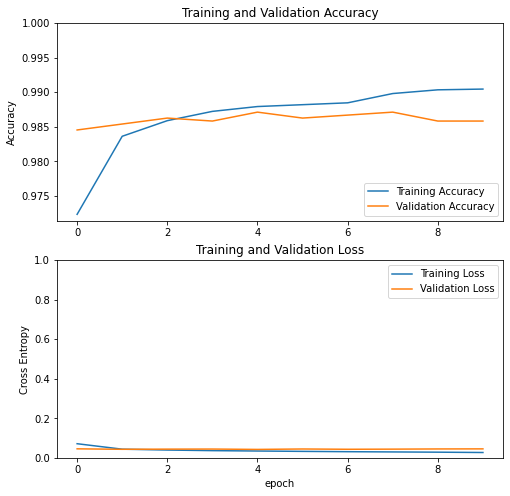

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [24]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [25]:
fine_tune_at = 100

# 'fine_tune"at'층 이전의 모든 층을 고정
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1862721 (7.11 MB)
Non-trainable params: 396544 (1.51 MB)
_________________________________________________________________


In [27]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1862721 (7.11 MB)
Non-trainable params: 396544 (1.51 MB)
_________________________________________________________________


In [28]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_batches)

Epoch 10/20
164/582 [=======>......................] - ETA: 56s - loss: 0.2178 - accuracy: 0.9253

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


196/582 [=========>....................] - ETA: 51s - loss: 0.2124 - accuracy: 0.9260

206/582 [=========>....................] - ETA: 50s - loss: 0.2088 - accuracy: 0.9275

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


278/582 [=============>................] - ETA: 40s - loss: 0.1992 - accuracy: 0.9268

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


486/582 [========================>.....] - ETA: 12s - loss: 0.1642 - accuracy: 0.9387

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


499/582 [========================>.....] - ETA: 11s - loss: 0.1643 - accuracy: 0.9389

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 9s - loss: 0.1624 - accuracy: 0.9396

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


537/582 [==========================>...] - ETA: 5s - loss: 0.1601 - accuracy: 0.9406

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


543/582 [==========================>...] - ETA: 5s - loss: 0.1593 - accuracy: 0.9408

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1550 - accuracy: 0.9420

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 87s 146ms/step - loss: 0.1550 - accuracy: 0.9420 - val_loss: 6.4531 - val_accuracy: 0.4914
Epoch 11/20
165/582 [=======>......................] - ETA: 56s - loss: 0.0945 - accuracy: 0.9655

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 52s - loss: 0.1007 - accuracy: 0.9653

207/582 [=========>....................] - ETA: 50s - loss: 0.1000 - accuracy: 0.9650

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 41s - loss: 0.0915 - accuracy: 0.9677

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 12s - loss: 0.0876 - accuracy: 0.9678

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 11s - loss: 0.0870 - accuracy: 0.9678

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 9s - loss: 0.0873 - accuracy: 0.9680

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 5s - loss: 0.0864 - accuracy: 0.9683

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 5s - loss: 0.0865 - accuracy: 0.9682

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0859 - accuracy: 0.9682

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 87s 148ms/step - loss: 0.0859 - accuracy: 0.9682 - val_loss: 1.2341 - val_accuracy: 0.7833
Epoch 12/20
164/582 [=======>......................] - ETA: 56s - loss: 0.0636 - accuracy: 0.9741

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


196/582 [=========>....................] - ETA: 51s - loss: 0.0647 - accuracy: 0.9735

206/582 [=========>....................] - ETA: 50s - loss: 0.0653 - accuracy: 0.9731

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


278/582 [=============>................] - ETA: 40s - loss: 0.0647 - accuracy: 0.9761

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


486/582 [========================>.....] - ETA: 12s - loss: 0.0603 - accuracy: 0.9779

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


499/582 [========================>.....] - ETA: 11s - loss: 0.0594 - accuracy: 0.9781

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 9s - loss: 0.0586 - accuracy: 0.9783

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


537/582 [==========================>...] - ETA: 5s - loss: 0.0596 - accuracy: 0.9784

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


543/582 [==========================>...] - ETA: 5s - loss: 0.0592 - accuracy: 0.9785

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0591 - accuracy: 0.9786

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 85s 146ms/step - loss: 0.0591 - accuracy: 0.9786 - val_loss: 4.6019 - val_accuracy: 0.6965
Epoch 13/20
165/582 [=======>......................] - ETA: 56s - loss: 0.0505 - accuracy: 0.9830

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 51s - loss: 0.0491 - accuracy: 0.9833

207/582 [=========>....................] - ETA: 50s - loss: 0.0495 - accuracy: 0.9829

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 40s - loss: 0.0444 - accuracy: 0.9847

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 12s - loss: 0.0431 - accuracy: 0.9851

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 10s - loss: 0.0429 - accuracy: 0.9852

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 9s - loss: 0.0425 - accuracy: 0.9854

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 5s - loss: 0.0420 - accuracy: 0.9855

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 5s - loss: 0.0420 - accuracy: 0.9855

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0421 - accuracy: 0.9855

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 85s 146ms/step - loss: 0.0421 - accuracy: 0.9855 - val_loss: 3.0001 - val_accuracy: 0.8113
Epoch 14/20
164/582 [=======>......................] - ETA: 58s - loss: 0.0303 - accuracy: 0.9888

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


196/582 [=========>....................] - ETA: 54s - loss: 0.0304 - accuracy: 0.9893

206/582 [=========>....................] - ETA: 52s - loss: 0.0302 - accuracy: 0.9895

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


278/582 [=============>................] - ETA: 42s - loss: 0.0292 - accuracy: 0.9902

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


486/582 [========================>.....] - ETA: 13s - loss: 0.0288 - accuracy: 0.9899

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


499/582 [========================>.....] - ETA: 11s - loss: 0.0283 - accuracy: 0.9900

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 10s - loss: 0.0279 - accuracy: 0.9901

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


537/582 [==========================>...] - ETA: 6s - loss: 0.0291 - accuracy: 0.9900

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


543/582 [==========================>...] - ETA: 5s - loss: 0.0289 - accuracy: 0.9901

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0283 - accuracy: 0.9901

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 89s 153ms/step - loss: 0.0283 - accuracy: 0.9901 - val_loss: 1.8539 - val_accuracy: 0.8792
Epoch 15/20
164/582 [=======>......................] - ETA: 59s - loss: 0.0284 - accuracy: 0.9909

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


196/582 [=========>....................] - ETA: 54s - loss: 0.0285 - accuracy: 0.9904

206/582 [=========>....................] - ETA: 52s - loss: 0.0273 - accuracy: 0.9909

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


278/582 [=============>................] - ETA: 42s - loss: 0.0260 - accuracy: 0.9910

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


486/582 [========================>.....] - ETA: 12s - loss: 0.0232 - accuracy: 0.9920

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


499/582 [========================>.....] - ETA: 11s - loss: 0.0235 - accuracy: 0.9920

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 9s - loss: 0.0233 - accuracy: 0.9920

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


537/582 [==========================>...] - ETA: 6s - loss: 0.0244 - accuracy: 0.9918

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


543/582 [==========================>...] - ETA: 5s - loss: 0.0242 - accuracy: 0.9918

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 0.9917

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 87s 149ms/step - loss: 0.0238 - accuracy: 0.9917 - val_loss: 0.9584 - val_accuracy: 0.9424
Epoch 16/20
165/582 [=======>......................] - ETA: 58s - loss: 0.0172 - accuracy: 0.9947

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 53s - loss: 0.0199 - accuracy: 0.9941

207/582 [=========>....................] - ETA: 52s - loss: 0.0198 - accuracy: 0.9940

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 42s - loss: 0.0198 - accuracy: 0.9943

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 13s - loss: 0.0207 - accuracy: 0.9944

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 11s - loss: 0.0206 - accuracy: 0.9944

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 9s - loss: 0.0202 - accuracy: 0.9945

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 6s - loss: 0.0206 - accuracy: 0.9944

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 5s - loss: 0.0204 - accuracy: 0.9945

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0194 - accuracy: 0.9947

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 88s 151ms/step - loss: 0.0194 - accuracy: 0.9947 - val_loss: 0.5805 - val_accuracy: 0.9695
Epoch 17/20
165/582 [=======>......................] - ETA: 56s - loss: 0.0173 - accuracy: 0.9964

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 52s - loss: 0.0220 - accuracy: 0.9952

207/582 [=========>....................] - ETA: 51s - loss: 0.0210 - accuracy: 0.9955

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 41s - loss: 0.0179 - accuracy: 0.9955

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 12s - loss: 0.0170 - accuracy: 0.9954

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 11s - loss: 0.0166 - accuracy: 0.9955

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 9s - loss: 0.0164 - accuracy: 0.9955

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 5s - loss: 0.0157 - accuracy: 0.9956

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 5s - loss: 0.0156 - accuracy: 0.9957

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0156 - accuracy: 0.9958

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 86s 148ms/step - loss: 0.0156 - accuracy: 0.9958 - val_loss: 0.7527 - val_accuracy: 0.9407
Epoch 18/20
165/582 [=======>......................] - ETA: 57s - loss: 0.0234 - accuracy: 0.9947

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 53s - loss: 0.0216 - accuracy: 0.9951

207/582 [=========>....................] - ETA: 51s - loss: 0.0208 - accuracy: 0.9952

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 41s - loss: 0.0180 - accuracy: 0.9956

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 13s - loss: 0.0194 - accuracy: 0.9956

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 11s - loss: 0.0189 - accuracy: 0.9958

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 9s - loss: 0.0187 - accuracy: 0.9958

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 6s - loss: 0.0188 - accuracy: 0.9957

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 5s - loss: 0.0192 - accuracy: 0.9956

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0188 - accuracy: 0.9957

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 88s 151ms/step - loss: 0.0188 - accuracy: 0.9957 - val_loss: 0.5519 - val_accuracy: 0.9669
Epoch 19/20
164/582 [=======>......................] - ETA: 59s - loss: 0.0094 - accuracy: 0.9962

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


196/582 [=========>....................] - ETA: 54s - loss: 0.0108 - accuracy: 0.9960

206/582 [=========>....................] - ETA: 53s - loss: 0.0105 - accuracy: 0.9961

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


278/582 [=============>................] - ETA: 43s - loss: 0.0094 - accuracy: 0.9967

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


486/582 [========================>.....] - ETA: 13s - loss: 0.0116 - accuracy: 0.9967

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


499/582 [========================>.....] - ETA: 11s - loss: 0.0115 - accuracy: 0.9967

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 10s - loss: 0.0113 - accuracy: 0.9968

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


537/582 [==========================>...] - ETA: 6s - loss: 0.0108 - accuracy: 0.9970

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


543/582 [==========================>...] - ETA: 5s - loss: 0.0107 - accuracy: 0.9970

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9970

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 88s 151ms/step - loss: 0.0105 - accuracy: 0.9970 - val_loss: 0.3441 - val_accuracy: 0.9725
Epoch 20/20
164/582 [=======>......................] - ETA: 1:00 - loss: 0.0100 - accuracy: 0.9973

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


196/582 [=========>....................] - ETA: 55s - loss: 0.0084 - accuracy: 0.9978

206/582 [=========>....................] - ETA: 53s - loss: 0.0089 - accuracy: 0.9977

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


278/582 [=============>................] - ETA: 42s - loss: 0.0090 - accuracy: 0.9972

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


486/582 [========================>.....] - ETA: 13s - loss: 0.0105 - accuracy: 0.9970

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


499/582 [========================>.....] - ETA: 11s - loss: 0.0103 - accuracy: 0.9971

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


510/582 [=========================>....] - ETA: 9s - loss: 0.0100 - accuracy: 0.9971 

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


537/582 [==========================>...] - ETA: 6s - loss: 0.0096 - accuracy: 0.9973

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


543/582 [==========================>...] - ETA: 5s - loss: 0.0094 - accuracy: 0.9973

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 0.9972

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 88s 151ms/step - loss: 0.0100 - accuracy: 0.9972 - val_loss: 0.7047 - val_accuracy: 0.9656


In [33]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

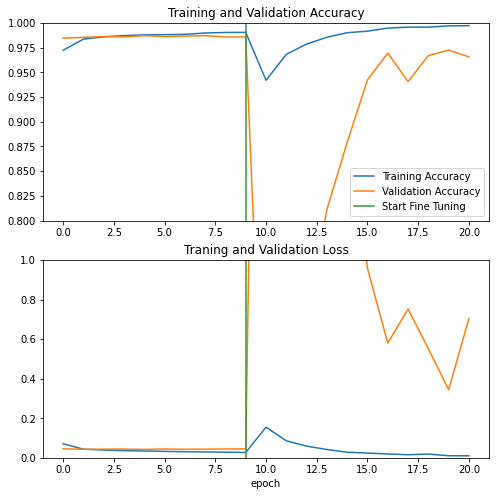

In [34]:
plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.title('Traning and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [43]:
import matplotlib.pylab as plt

import tensorflow_hub as hub
from tensorflow.keras import layers

In [52]:
url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
classifier_url = url

In [53]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:997)>

61306/61306 [==============================] - 0s 0us/step


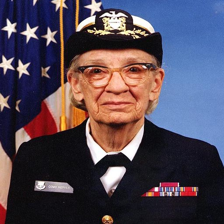

In [46]:
import PIL.Image as Image

url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg'
grace_hopper = tf.keras.utils.get_file('image.jpg', url)
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [49]:
grace_hopper = np.array(grace_hopper) / 255.0
grace_hopper.shape

(224, 224, 3)

In [51]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

NameError: name 'classifier' is not defined

In [55]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

NameError: name 'result' is not defined

In [ ]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', url)
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [ ]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [ ]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
data_root = tf.keras.utils.get_file(
    'flower_photos', url,
    untar=True
)

In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

In [ ]:
for image_batch, label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

In [ ]:
result_batch = classifier.predict(image_batch)
result_batch.shape

In [ ]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

In [ ]:
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6, 5, n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
_ = plt.subtitle("imageNet predictions")

In [ ]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview-mobilenet_v2/feature_vector/2"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=(224, 224, 3))

In [ ]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

In [ ]:
feature_extractor_layer.trainable = False

model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

In [ ]:
predictions = model(image_batch)
predictions.shape

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [ ]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
        
    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

In [ ]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

In [ ]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0, 2])
plt.plot(batch_stats_callback.batch_losses)

In [ ]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0, 1])
plt.plot(batch_stats_callback.batch_acc)

In [ ]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair: pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis=-1)

In [ ]:
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6, 5, n+1)
    plt.imshow(image_batch[n])
    color="green" if predicted_id[n] == label_id[n] else "red"
    plt.title(predicted_label_batch[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [ ]:
import time
t = time.time()

export_path = "./{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

In [ ]:
reloaded = tf.keras.models.load_model(export_path)
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)
abs(reloaded_result_batch - result_batch).max()